In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds 
from tensorflow.keras.optimizers.schedules import PolynomialDecay 
from tensorflow.keras.optimizers import Adam 
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split 
from transformers import AutoTokenizer 
from transformers import TFAutoModelForSequenceClassification

In [4]:
#load data
ds = tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00', split='train', shuffle_files=True)
df = tfds.as_dataframe(ds.take(2000))

2022-09-05 19:01:40.895652: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/104975 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0.incompleteENWILR/amazon_us_re…

Dataset amazon_us_reviews downloaded and prepared to ~/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0. Subsequent calls will reuse this data.


2022-09-05 19:02:40.556216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-05 19:02:41.672537: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
df.head()

,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine
0,b'20980074',0,b'US',b'Mobile_Electronics',b'B00D1847NE',b'274617424',b'Teenage Mutant Ninja Turtles Boombox CD Play...,b'Does not work',b'2015-01-09',b'One Star',b'R1OVS0D6SEXPW7',1,0,0,1
1,b'779273',0,b'US',b'Mobile_Electronics',b'B00KMO6DYG',b'397452138',b'4 Gauge Amp Kit Amplifier Install Wiring Com...,b'This is a great wiring kit i used it to set ...,b'2015-08-06',b'Great kit',b'R9VSD0ET8FERB',4,0,0,1
2,b'15410531',0,b'US',b'Mobile_Electronics',b'B000GWLL0K',b'948304826',b'Travel Wall Charger fits Creative Zen Vision...,b'It works great so much faster than USB charg...,b'2007-03-15',b'A/C Charger for Creative Zen Vision M',b'R3ISXCZHWLJLBH',5,0,0,1
3,b'27389005',0,b'US',b'Mobile_Electronics',b'B008L3JE6Y',b'466340015',b'High Grade Robust 360\xc2\xb0 Adjustable Car...,b'This product was purchased to hold a monitor...,b'2013-07-30',b'camera stand',b'R1TWVUDOFJSQAW',5,0,0,1
4,b'2663569',0,b'US',b'Mobile_Electronics',b'B00GHZS4SC',b'350592810',b'HDE Multifunctional Bluetooth FM Audio Car K...,"b""it works but it has really bad sound quality...",b'2014-12-31',b'bad sound quality',b'R2PEOEUR1LP0GH',3,0,0,1


In [7]:
df["label"] = df["data/star_rating"].apply(lambda score: 1 if score >= 3 else 0) #creating a binary label
df['review'] =df['data/review_body'].str.decode("utf-8") #data enconde is correct
df = df[["review", "label", ]] 
# Get the underlying numpy arrays 
reviews = df['review'].values 
labels = df['label'].values

In [8]:
df.head()

,review,label
0,Does not work,0
1,This is a great wiring kit i used it to set up...,1
2,It works great so much faster than USB charger...,1
3,This product was purchased to hold a monitor o...,1
4,it works but it has really bad sound quality. ...,1


In [23]:
df['label'].value_counts()/df.shape[0]

1    0.7715
0    0.2285
Name: label, dtype: float64

In [9]:
train_reviews, val_reviews, train_labels, val_labels = train_test_split(reviews, labels, test_size=.33333333)

In [24]:
checkpoint = "distilbert-base-uncased" 
#Assign tokenizer object to the tokenizer class 
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [30]:
#setting up model

def tokenize_dataset(reviews):
    encoded = tokenizer(
        reviews,
        padding=True,
        truncation=True,
        return_tensors='np',
    )
    return encoded.data

tokenized_datasets = {
    "train": tokenize_dataset(train_reviews.tolist()),
    "validation": tokenize_dataset(val_reviews.tolist()),
}

In [31]:
batch_size = 8
num_epochs = 5
num_train_steps = (len(train_reviews) // batch_size) * num_epochs

In [33]:
lr_scheduler = PolynomialDecay(
    initial_learning_rate=1e-5,
    end_learning_rate=0.,
    decay_steps=num_train_steps
)

# The optimizer is Adam with the learning rate schedule as specified
opt = Adam(learning_rate=lr_scheduler)

In [40]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_39', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [41]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(
    tokenized_datasets['train'],
    train_labels, 
    validation_data=(tokenized_datasets['validation'], val_labels),
    batch_size=batch_size,
    epochs=num_epochs
)

Epoch 1/5
167/167 [==============================] - 6691s 40s/step - loss: 0.4615 - accuracy: 0.7824 - val_loss: 0.2844 - val_accuracy: 0.8786
Epoch 2/5
167/167 [==============================] - 2030s 12s/step - loss: 0.2106 - accuracy: 0.9272 - val_loss: 0.2490 - val_accuracy: 0.9070
Epoch 3/5
167/167 [==============================] - 1740s 10s/step - loss: 0.1215 - accuracy: 0.9572 - val_loss: 0.2582 - val_accuracy: 0.9070
Epoch 4/5
167/167 [==============================] - 1730s 10s/step - loss: 0.0761 - accuracy: 0.9835 - val_loss: 0.2438 - val_accuracy: 0.9175
Epoch 5/5
167/167 [==============================] - 1732s 10s/step - loss: 0.0579 - accuracy: 0.9887 - val_loss: 0.2606 - val_accuracy: 0.9100


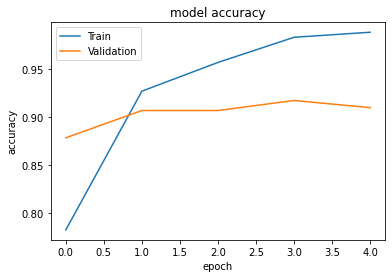

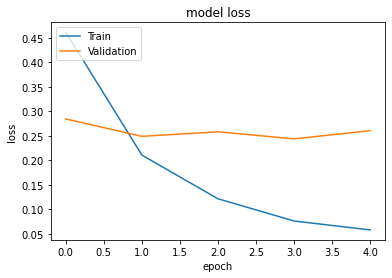

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
for m in ('accuracy', 'loss'):
    plt.plot(history.history[m])
    plt.plot(history.history['val_'+m])
    plt.title('model '+m)
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [ ]:
# testing model
test_reviews = [
                "This is a great phone",
                "The item is dead on arrival",
                "Had to return it because the charging cable was broken"
                "I am not sure if I like this Iphone",
                "I think it's an okay product, but I might not buy again",
]

# it's important to use the same tokenize function to feed to the model
tokenized_inputs = tokenize_dataset(test_reviews)
tf_output = model.predict(tokenized_inputs)
tf_prediction = tf.nn.softmax(tf_output.logits, axis=1)
labels = ['Negative','Positive']
label = tf.argmax(tf_prediction, axis=1)
for i in range(len(test_reviews)):
    print("Sentense [{}]: {}".format(i, test_reviews[i]))
    print("Probabilities:", tf_prediction[i])
    print("Predition:", labels[label[i]])
    print()

1/1 [==============================] - 2s 2s/step
Sentense [0]: This is a great phone
Probabilities: tf.Tensor([0.00871482 0.99128515], shape=(2,), dtype=float32)
Predition: Positive

Sentense [1]: The item is dead on arrival
Probabilities: tf.Tensor([0.945176   0.05482402], shape=(2,), dtype=float32)
Predition: Negative

Sentense [2]: Had to return it because the charging cable was brokenI am not sure if I like this Iphone
Probabilities: tf.Tensor([0.94061714 0.05938287], shape=(2,), dtype=float32)
Predition: Negative

Sentense [3]: I think it's an okay product, but I might not buy again
Probabilities: tf.Tensor([0.25944567 0.74055433], shape=(2,), dtype=float32)
Predition: Positive

